In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


### Feature Extraction 

In [74]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients



def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        # my added features
        #######
        y = waveform
        sr = sample_rate
        stft_=np.abs(librosa.stft(waveform))

        cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
        contrast = np.mean( librosa.feature.spectral_contrast(S=stft_, sr=sr).T, axis=0)
        tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate).T,axis=0)
        rms = np.mean( librosa.feature.rms(y=y).T, axis=0)
        spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
        rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
        zcr = np.mean( librosa.feature.zero_crossing_rate(y).T, axis=0) 
        #######

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients, cent, contrast, tonnetz, rms, spec_bw, rolloff, zcr ))
        
        return feature_matrix

In [75]:
#import os, glob

#def load_data():
#    X,y=[],[]
#    count = 0
#    for file in glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav'):
#        file_name=os.path.basename(file)
#        fileID = file.split('/')[-1]
#        features = get_features(file)
#        X.append(features)
       # y.append(emotion)
#        count += 1
        # '\r' + end='' results in printing over same line
#        print('\r' + f' Processed {count}/{20000} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
#    return np.array(X)

In [76]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))

            X.append(xi)
            y.append(label)
    return np.array(X),np.array(y)

In [77]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')


labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')


X,y = getXy(files[:5000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

a,b = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)



  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=624
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=312
  n_fft, y.shape[-1]
  0%|          | 2/5000 [00:00<22:41,  3.67it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=678
  n_fft, y.shape[-1]
  0%|          | 4/5000 [00:01<26:28,  3.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small 

In [78]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
#print('The labels vector is', y)

The shape of X is (1635, 202)
The shape of y is (1635,)


### Best Feature Selection

In [264]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
X_new = SelectKBest(mutual_info_classif, k=200).fit_transform(X, y)
#X_new = SelectKBest(mutual_info_classif, k=10).fit_transform(a, b)

X_new.shape


(1635, 200)

In [265]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 1635
Numerical features extracted per sample: 200


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.038618,187.723934,62.598813,0.291139,0.770630,0.802456,0.804408,0.779138,0.814540,0.774460,0.734193,0.782229,0.821627,0.762123,0.781257,14.515042,1.052103,0.201007,10.480879,25.117332,7.487123,2.719220,2.415112,13.006311,6.930757,4.028258,1.122513,16.505573,31.761347,19.780783,17.342100,13.774872,37.632626,29.616724,20.804863,10.572713,108.069725,159.981689,44.133759,9.171792,...,2.286113,2.103068,2.422491,3.131922,0.121986,3.516499,2.961297,0.080861,1.832576,2.122889,2.434273,3.909112,2.030295,1.435455,3.139641,1.044347,-0.696862,0.902722,0.676519,0.748781,2.655575,3.133205,1903.733078,20.424254,13.342550,14.491569,14.183094,16.279184,16.970255,23.182474,-0.011535,-0.007067,-0.014633,0.109221,0.028545,-0.007721,0.100528,2277.251051,4332.211304,0.049207
1,0.006295,130.283099,5.193614,0.241176,0.804258,0.761314,0.687007,0.703819,0.642448,0.629949,0.655282,0.637359,0.600166,0.663774,0.877174,0.000001,0.000005,0.009029,0.209567,0.066930,0.000284,0.003845,0.257284,0.231254,0.006217,0.000756,0.034149,0.036772,0.003140,0.000582,0.004427,0.005828,0.000962,0.000829,0.043505,0.109088,0.061417,0.008087,0.019217,0.089656,...,-0.478283,-1.734301,-2.577405,-1.184985,-4.630558,-4.899690,-0.775364,0.101823,0.510881,2.702301,1.911880,1.296045,2.152524,-0.376525,-1.800843,-2.294783,-1.353599,-1.971972,-2.495365,-0.589573,-0.842134,-1.351545,3690.346387,26.646126,14.345018,19.123000,15.311646,16.080727,16.492509,17.941194,0.027366,-0.051203,0.108547,0.073788,-0.025854,-0.002581,0.003459,2967.029267,7202.983111,0.256152
2,0.017070,171.916609,26.854425,0.111888,0.771860,0.764209,0.783288,0.651190,0.629808,0.650154,0.639232,0.660599,0.789083,0.885277,0.825083,0.018878,0.010611,0.003205,0.061722,0.389000,0.268590,0.508174,0.266551,0.174884,0.774053,0.515217,0.703575,1.385456,6.712080,13.318813,5.195361,4.526732,3.474549,1.465512,0.509539,0.498330,0.211244,0.040064,0.044417,0.051937,...,4.971224,0.946319,2.647785,5.649402,-0.723506,4.149464,1.807690,3.836558,0.359892,5.440084,-1.577403,5.861119,-0.405031,3.262117,2.221086,0.295656,0.892276,2.682902,0.229054,2.338452,0.585328,0.290279,3290.033066,18.534426,11.520795,14.424355,13.932368,17.836964,17.417378,25.915687,0.016031,-0.003649,-0.017260,0.004529,0.020028,-0.026040,0.020261,2474.796863,6001.483154,0.208781
3,0.021679,165.671895,28.076065,0.588785,0.488695,0.519082,0.553939,0.623619,0.725543,0.775133,0.703245,0.633878,0.652575,0.637664,0.543146,0.000011,0.000027,0.105741,1.449543,20.612280,17.742716,1.093021,7.421634,6.091454,3.166740,2.248097,4.127024,0.626899,0.048198,0.019496,0.193911,0.119908,0.022272,0.008592,0.003658,0.002161,0.002264,0.003331,0.007083,0.004189,...,-15.119155,-13.412454,-13.413696,-8.887530,-4.990288,-0.197847,-8.801100,-4.479550,-9.556822,-6.435142,-7.243377,-4.178809,-0.857305,-8.925093,-2.042154,-1.639325,1.399187,-0.493080,2.339715,4.926601,5.827867,6.684693,1983.699413,32.725808,16.178396,17.166961,16.582294,17.830107,17.432317,29.918392,0.022291,0.027191,-0.035781,0.034783,-0.012528,-0.009448,0.032884,2026.432981,4216.520182,0.082303
4,0.035376,105.684323,8.642074,0.275862,0.714868,0.709244,0.719796,0.666762,0.599184,0.573831,0.596318,0.657777,0.684871,0.721806,0.752549,0.001359,0.006728,0.558087,0.838032,2.399819,10.552579,11.509242,3.962417,3.346293,15.373562,17.825766,12.162240,28.166241,47.770676,70.435829,80.743095,110.402229,139.483841,89.845802,83.996696,53.823792,14.485119,6.113783,3.721339,3.218826,...,-6.648242,-5.038853,-1.586573,-4.659491,-4.273466,-0.030676,-6.345282,-5.738972,-3.573286,-1.859073,-4.491550,-1.516790,0.136003,-3.224302,-0.843685,-0.528791,0.966817,-2.165058,-2.046418,-0.774501,-1.292857,-0.453185,1743.764914,25.506249,15.056230,19.179357,17.574343,18.789302,22.7915

### Class Balance Check 

In [266]:
intonation_list = labels['intonation'].unique()
intonation_list

array(['question', 'excited', 'neutral', 'bored'], dtype=object)

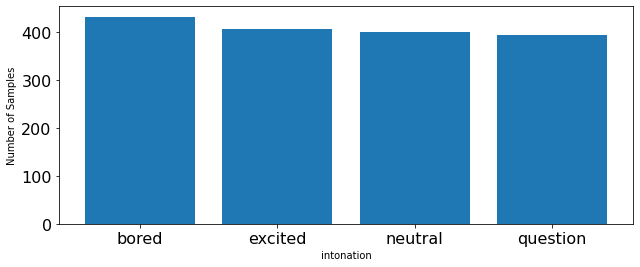

In [267]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(4), height=count)
plt.xticks(ticks=range(4), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [268]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


### Normalising

In [269]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_scaled = X
#features_scaled = a
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [270]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.106436,0.120512,1.269289,-0.144036,0.959221,1.401530,1.386176,1.207368,1.574241,1.155461,0.649420,0.979856,1.294125,0.747533,0.965589,1.112079,0.291453,-0.226244,0.987644,2.881497,0.459880,-0.173956,-0.183288,0.313178,0.057994,-0.090610,-0.248840,0.478089,1.148950,0.548259,0.467588,0.397258,1.867421,1.483701,0.651207,0.288189,6.503848,9.004164,3.840882,0.788728,...,1.175453,0.866726,1.384028,1.059285,0.763127,1.194175,1.545760,0.218253,1.028937,0.687591,1.084667,1.175087,0.928062,0.403800,1.154014,0.272789,0.096558,0.275212,0.563027,0.268493,1.259421,1.099073,-0.638173,-0.166866,-0.684496,-1.130948,-1.071713,-0.723689,-0.604665,-0.123384,-0.260641,-0.209952,-0.278952,1.191626,0.849880,-0.061453,2.512936,0.145184,-0.272831,-1.082017
1,-1.136919,-0.611835,-0.847291,-0.444028,1.283782,1.007360,0.308640,0.529508,0.037762,-0.165025,-0.110460,-0.461250,-0.898748,-0.260686,1.911431,-0.039855,-0.051835,-0.278319,-0.296221,-0.293643,-0.384438,-0.385430,-0.321087,-0.242841,-0.261823,-0.270659,-0.308451,-0.258614,-0.261244,-0.239519,-0.227063,-0.201690,-0.192399,-0.204783,-0.154242,-0.133125,-0.179168,-0.162248,-0.189906,-0.175893,...,0.612741,0.108406,0.275689,0.100612,-0.321850,-0.893880,0.539366,0.223813,0.667032,0.843084,0.943139,0.467982,0.962010,-0.049562,-0.206350,-0.660046,-0.099116,-0.625523,-0.505202,-0.199220,0.000968,-0.573219,1.668642,1.362476,-0.244205,0.987789,-0.527177,-0.827178,-0.828071,-1.455419,0.544175,-1.000523,1.069517,0.781831,-0.931793,0.104193,-0.956397,1.979562,1.886829,1.580259
2,-0.389096,-0.081025,-0.048638,-1.220314,0.971094,1.035104,1.192328,0.055864,-0.075088,0.019595,-0.265012,-0.230067,0.971876,2.010040,1.397753,-0.038357,-0.048374,-0.279898,-0.314701,-0.252821,-0.354180,-0.346153,-0.320495,-0.245295,-0.226360,-0.247660,-0.271786,-0.198283,0.036661,0.290901,-0.019083,-0.005033,-0.002268,-0.121277,-0.136162,-0.117453,-0.169898,-0.160416,-0.187603,-0.179900,...,1.722025,0.638136,1.433970,1.618351,0.570106,1.351213,1.235060,1.214507,0.625688,1.577804,-0.002188,1.703307,0.251673,0.860836,0.901089,0.063631,0.570039,0.833001,0.412329,0.824033,0.514560,0.038991,1.151771,-0.631388,-1.484623,-1.161696,-1.192690,0.088642,-0.395580,0.571243,0.309661,-0.148728,-0.307720,-0.019174,0.570934,-0.651777,-0.355852,0.670532,0.982950,0.970844
3,-0.069221,-0.160642,-0.003595,1.643119,-1.761869,-1.313369,-0.912685,-0.192273,0.779662,1.161613,0.351401,-0.495879,-0.379809,-0.528353,-1.382440,-0.039854,-0.051828,-0.252085,-0.141230,2.310481,1.616441,-0.300605,0.136429,0.012217,-0.115851,-0.170192,-0.084280,-0.232215,-0.259243,-0.238765,-0.219471,-0.196728,-0.191233,-0.204340,-0.155788,-0.137431,-0.182828,-0.162521,-0.191014,-0.184971,...,-2.367507,-2.199367,-2.126420,-1.609922,-0.403974,0.272646,-1.622204,-0.991464,-2.089697,-1.609068,-1.537229,-1.013533,0.126058,-2.188435,-0.272795,-0.476934,0.721072,-0.162138,1.123158,1.728510,2.400791,2.423367,-0.534923,2.856867,0.561027,0.092961,0.085922,0.085066,-0.388594,1.588502,0.439175,0.403701,-0.510469,0.330723,-0.495343,-0.117102,0.095270,-0.521835,-0.359865,-0.656251
4,0.881421,-0.925459,-0.720143,-0.235765,0.421041,0.508500,0.609586,0.196006,-0.348507,-0.677814,-0.678256,-0.258144,-0.060013,0.334228,0.682490,-0.039747,-0.049641,-0.129384,-0.217666,0.002051,0.805583,0.510613,-0.084477,-0.107263,0.447933,0.526208,0.355818,0.999708,1.859829,2.565675,3.007811,4.600515,7.442386,4.917527,3.102772,2.029678,0.713298,0.187605,0.148361,0.156458,...,-0.643195,-0.544622,0.495329,-0.670985,-0.240328,0.314121,-0.960779,-1.325545,-0.451291,-0.381020,-0.791697,-0.293181,0.401940,-0.762083,0.057204,-0.166690,0.592249,-0.686023,-0.354005,-0.263846,-0.161199,-0.238235,-0.844718,1.082293,0.068164,1.013571,0.564594,0.585255,2.1

### Dataset Spliting

In [209]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    b, 
    test_size=0.2, 
    stratify=b
)


## Comparing Models

In [276]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)

classification_models = [
    KNeighborsClassifier(),#(3),
    #SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_val_scaled, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
3,RandomForestClassifier,63.61%
1,SVC RBF kernel,54.74%
0,KNeighborsClassifier,51.99%
4,AdaBoostClassifier,47.09%
2,DecisionTreeClassifier,46.79%
6,QuadraticDiscriminantAnalysis,43.43%
5,GaussianNB,34.25%


### GridSearchCV SVM

In [283]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


param_grid = { 'C':[1,2,3,4,5,6,7,8,9],'kernel':['rbf'],'gamma': [ 1, 0.1, 0.01, 0.001 ]}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv= 5)
grid.fit(X_train_scaled,y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_val_scaled, y_val)))

#grid_predictions = grid.predict(X_val)
#print(confusion_matrix(y_val,grid_predictions))
#print(classification_report(y_val,grid_predictions))#Output

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.9min finished


{'C': 3, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Test dataset accuracy of best hyperparameter setting: 0.617737003058104.


### GridSearchCV RandomForestClassifier

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200,250,280,300,350],
    'max_features': ['sqrt']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val_scaled, y_val)))

0.5772308502237431
{'max_features': 'sqrt', 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)
Test dataset accuracy (random forest classifier): 0.6269113149847095.
